# 🚨 Early Warning System (EWS) for Student Performance
## Temporal Prediction Approach

---

**Module:** WM9QG-15 Fundamentals of AI and Data Mining

**Approach:** This notebook implements a **temporal early warning system** where we predict student success at different points in time during the course.

---

## 📋 Table of Contents

1. [Understanding the Temporal Approach](#1)
2. [Setup and Data Loading](#2)
3. [Build the Feature Store](#3)
4. [Data Cleaning](#4)
5. [Early Warning Classification](#5)
6. [Evaluation](#6)
7. [Critique and Limitations](#7)

---

<a id='1'></a>
# 1️⃣ Understanding the Temporal Approach

## The Key Insight

Traditional approaches create **one row per student** with aggregated features. But in a real early warning system, we need to make predictions **at different points in time**:

- At **Week 2**: Can we identify at-risk students?
- At **Week 4**: Has our prediction improved with more data?
- At **Week 6**: Are interventions working?

## Data Structure: Student-Week Snapshots

This approach creates **one row per student per week**:

```
| student_id | week | cum_clicks | cum_resources | ... | target_pass |
|------------|------|------------|---------------|-----|-------------|
| 12345      |  0   |    50      |      10       | ... |      1      |
| 12345      |  1   |   120      |      25       | ... |      1      |
| 12345      |  2   |   200      |      40       | ... |      1      |
| 67890      |  0   |    10      |       3       | ... |      0      |
| 67890      |  1   |    15      |       5       | ... |      0      |
```

**Key features:**
- `cum_*` columns are **cumulative** (sum up to that week)
- Same student appears multiple times (one row per week they were active)
- Target is the **same** for all rows of a student (final outcome)

## Why Cumulative Features?

At week 2, we only know what happened in weeks 0, 1, and 2. Cumulative features capture:
- Total engagement **so far**
- Trajectory of behavior (is it increasing week by week?)

## Preventing Data Leakage

⚠️ **Critical**: Because each student has multiple rows, we CANNOT use random train/test split!

If student 12345's week 0 row is in training and week 2 row is in test, the model has already "seen" this student → **data leakage**.

**Solution**: Use `GroupShuffleSplit` to keep ALL of a student's rows in either train OR test.

---

<a id='2'></a>
# 2️⃣ Setup and Data Loading

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    roc_curve, accuracy_score, f1_score
)

print("✓ Libraries loaded")

✓ Libraries loaded


In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Update this path to where your OULAD data files are located
DATA_DIR = Path(".")  # Current directory, change if needed

# Key columns used throughout (student + module combination)
KEY_COLS = ["student_id", "code_module", "code_presentation"]

print(f"Data directory: {DATA_DIR.resolve()}")

Data directory: C:\Users\mertf\Desktop\FAIDM\FAIDM_Groupwork


In [4]:
# =============================================================================
# LOAD ALL OULAD TABLES
# =============================================================================

def load_csv(name: str) -> pd.DataFrame:
    """Load a CSV file from the data directory."""
    return pd.read_csv(DATA_DIR / name)

print("Loading OULAD tables...")
print("-" * 60)

assessments          = load_csv("assessments.csv")
courses              = load_csv("courses.csv")
student_assessment   = load_csv("studentAssessment.csv")
student_info         = load_csv("studentInfo.csv")
student_registration = load_csv("studentRegistration.csv")
student_vle          = load_csv("studentVle.csv")
vle                  = load_csv("vle.csv")

# Standardize column names: id_student → student_id
student_assessment   = student_assessment.rename(columns={"id_student": "student_id"})
student_info         = student_info.rename(columns={"id_student": "student_id"})
student_registration = student_registration.rename(columns={"id_student": "student_id"})
student_vle          = student_vle.rename(columns={"id_student": "student_id"})

# Print summary
tables = {
    "assessments": assessments,
    "courses": courses,
    "student_assessment": student_assessment,
    "student_info": student_info,
    "student_registration": student_registration,
    "student_vle": student_vle,
    "vle": vle,
}

for name, df in tables.items():
    print(f"✓ {name}: {df.shape[0]:,} rows × {df.shape[1]} cols")

print("-" * 60)

Loading OULAD tables...
------------------------------------------------------------
✓ assessments: 206 rows × 6 cols
✓ courses: 22 rows × 3 cols
✓ student_assessment: 173,912 rows × 5 cols
✓ student_info: 32,593 rows × 12 cols
✓ student_registration: 32,593 rows × 5 cols
✓ student_vle: 10,655,280 rows × 6 cols
✓ vle: 6,364 rows × 6 cols
------------------------------------------------------------


---

<a id='3'></a>
# 3️⃣ Build the Feature Store

The "feature store" is a single table with one row per student per week, containing:
1. **Cumulative VLE engagement** by activity type
2. **Demographics** (static features)
3. **Course information**
4. **Target variables**

## 3.1 Demographics (Static Features)

In [5]:
# =============================================================================
# DEMOGRAPHICS
# =============================================================================
# These are static features that don't change over time
# =============================================================================

demographics = student_info[KEY_COLS + [
    "gender",
    "region",
    "highest_education",
    "imd_band",
    "age_band",
    "num_of_prev_attempts",
    "studied_credits",
    "disability",
]].copy()

print(f"Demographics: {demographics.shape}")
demographics.head()

Demographics: (32593, 11)


,student_id,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,11391,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,28400,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,30268,AAA,2013J,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,31604,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,32885,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


## 3.2 Course Features

In [6]:
# =============================================================================
# COURSE FEATURES
# =============================================================================

course_features = courses[[
    "code_module", 
    "code_presentation", 
    "module_presentation_length"
]].copy()

print(f"Course features: {course_features.shape}")
course_features.head()

Course features: (22, 3)


,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


## 3.3 Registration Features

In [7]:
# =============================================================================
# REGISTRATION FEATURES
# =============================================================================

registration_features = student_registration[KEY_COLS + [
    "date_registration",
    "date_unregistration",
]].copy()

print(f"Registration features: {registration_features.shape}")
registration_features.head()

Registration features: (32593, 5)


,student_id,code_module,code_presentation,date_registration,date_unregistration
0,11391,AAA,2013J,-159.0,NaN
1,28400,AAA,2013J,-53.0,NaN
2,30268,AAA,2013J,-92.0,12.0
3,31604,AAA,2013J,-52.0,NaN
4,32885,AAA,2013J,-176.0,NaN


## 3.4 Target Variables

In [8]:
# =============================================================================
# TARGET VARIABLES
# =============================================================================
# target_pass: Binary classification target (1 = Pass/Distinction, 0 = Fail/Withdrawn)
# target_score: Regression target (weighted average assessment score)
# =============================================================================

# Classification target
targets = student_info[KEY_COLS + ["final_result"]].copy()
targets["target_pass"] = targets["final_result"].isin(["Pass", "Distinction"]).astype(int)

# Regression target: compute weighted final score
def safe_weighted_average(g):
    w = g["weight"].fillna(0)
    if w.sum() == 0:
        return np.nan
    return np.average(g["score"].fillna(0), weights=w)

score_df = (
    student_assessment
    .merge(assessments[["id_assessment", "code_module", "code_presentation", "weight"]], 
           on="id_assessment", how="left")
)

score_agg = (
    score_df
    .groupby(KEY_COLS)
    .apply(lambda g: pd.Series({
        "target_score": safe_weighted_average(g),
        "weight_covered": g["weight"].sum()
    }))
    .reset_index()
)

# Merge targets
targets = targets.merge(score_agg, on=KEY_COLS, how="left")

print("Target distribution (target_pass):")
print(targets["target_pass"].value_counts())
print(f"\nSuccess rate: {targets['target_pass'].mean()*100:.1f}%")

Target distribution (target_pass):
target_pass
0    17208
1    15385
Name: count, dtype: int64

Success rate: 47.2%


## 3.5 Weekly VLE Engagement Features (The Key Innovation)

This is where the temporal approach differs from traditional methods:
1. Convert VLE interaction dates to **week numbers**
2. Aggregate clicks by **student × week × activity type**
3. Compute **cumulative** totals (running sum up to each week)

In [9]:
# =============================================================================
# STEP 1: Convert dates to weeks and add activity type
# =============================================================================

# Merge VLE activity type into student_vle
vle_interactions = student_vle.merge(
    vle[["id_site", "code_module", "code_presentation", "activity_type"]],
    on=["id_site", "code_module", "code_presentation"],
    how="left"
)

# Convert date (days from start) to week number
vle_interactions["week"] = (vle_interactions["date"] // 7).astype(int)

print(f"VLE interactions with week: {vle_interactions.shape}")
print(f"Week range: {vle_interactions['week'].min()} to {vle_interactions['week'].max()}")
print(f"\nActivity types: {vle_interactions['activity_type'].nunique()}")
print(vle_interactions['activity_type'].value_counts().head(10))

VLE interactions with week: (10655280, 8)
Week range: -4 to 38

Activity types: 20
activity_type
forumng          2408457
oucontent        1963782
subpage          1949898
homepage         1735226
quiz              914573
resource          813185
url               407716
ouwiki            178165
oucollaborate      65793
externalquiz       50910
Name: count, dtype: int64


In [10]:
# =============================================================================
# STEP 2: Aggregate by student × week × activity type
# =============================================================================

weekly_by_type = (
    vle_interactions
    .groupby(KEY_COLS + ["week", "activity_type"])
    .agg(
        weekly_clicks=("sum_click", "sum"),
        weekly_active_days=("date", "nunique"),
        weekly_n_resources=("id_site", "nunique"),
    )
    .reset_index()
)

print(f"Weekly aggregates by type: {weekly_by_type.shape}")
weekly_by_type.head()

Weekly aggregates by type: (2518170, 8)


,student_id,code_module,code_presentation,week,activity_type,weekly_clicks,weekly_active_days,weekly_n_resources
0,6516,AAA,2014J,-4,forumng,33,1,1
1,6516,AAA,2014J,-4,homepage,16,2,1
2,6516,AAA,2014J,-4,oucontent,57,2,5
3,6516,AAA,2014J,-4,resource,2,1,1
4,6516,AAA,2014J,-4,subpage,2,1,1


In [11]:
# =============================================================================
# STEP 3: Pivot to wide format (one column per activity type)
# =============================================================================

def pivot_metric(df: pd.DataFrame, value_col: str, prefix: str) -> pd.DataFrame:
    """Pivot a metric to wide format with activity types as columns."""
    wide = (
        df.pivot_table(
            index=KEY_COLS + ["week"],
            columns="activity_type",
            values=value_col,
            aggfunc="sum",
            fill_value=0,
        )
        .reset_index()
    )
    # Rename columns to include prefix
    wide.columns = [
        f"{prefix}_{c}".lower().replace(" ", "_")
        if c not in KEY_COLS + ["week"] else c
        for c in wide.columns
    ]
    return wide

# Pivot each metric
weekly_clicks_wide = pivot_metric(weekly_by_type, "weekly_clicks", "weekly_clicks")
weekly_days_wide   = pivot_metric(weekly_by_type, "weekly_active_days", "weekly_days")
weekly_res_wide    = pivot_metric(weekly_by_type, "weekly_n_resources", "weekly_resources")

# Merge all weekly metrics
weekly_wide = (
    weekly_clicks_wide
    .merge(weekly_days_wide, on=KEY_COLS + ["week"], how="left")
    .merge(weekly_res_wide, on=KEY_COLS + ["week"], how="left")
)

print(f"Weekly wide format: {weekly_wide.shape}")
print(f"Columns: {len(weekly_wide.columns)}")

Weekly wide format: (627031, 64)
Columns: 64


In [12]:
# =============================================================================
# STEP 4: Compute CUMULATIVE features (running sum up to each week)
# =============================================================================
# This is the KEY to temporal prediction:
# At week 3, cum_clicks = clicks from weeks 0 + 1 + 2 + 3
# =============================================================================

weekly_wide = weekly_wide.sort_values(KEY_COLS + ["week"]).copy()

# Get all weekly feature columns (exclude keys and week)
weekly_feature_cols = [c for c in weekly_wide.columns if c not in KEY_COLS + ["week"]]

# Create cumulative column names
cum_cols = ["cum_" + c for c in weekly_feature_cols]

# Compute cumulative sum within each student
weekly_wide[cum_cols] = (
    weekly_wide
    .groupby(KEY_COLS)[weekly_feature_cols]
    .cumsum()
)

# Keep only cumulative features (drop weekly)
ews_features = weekly_wide[KEY_COLS + ["week"] + cum_cols].copy()

print(f"EWS features (cumulative): {ews_features.shape}")
print(f"\nExample of cumulative features for one student:")
sample_student = ews_features[KEY_COLS[0]].iloc[0]
print(ews_features[ews_features[KEY_COLS[0]] == sample_student][[KEY_COLS[0], "week", cum_cols[0], cum_cols[1]]].head(10))

EWS features (cumulative): (627031, 64)

Example of cumulative features for one student:
   student_id  week  cum_weekly_clicks_dataplus  cum_weekly_clicks_dualpane
0        6516    -4                           0                           0
1        6516    -3                           0                           0
2        6516    -2                           0                           0
3        6516    -1                           0                           0
4        6516     0                           0                           0
5        6516     1                           0                           0
6        6516     2                           0                           0
7        6516     3                           0                           0
8        6516     4                           7                           0
9        6516     5                           7                           0


## 3.6 Build Complete Feature Store

In [13]:
# =============================================================================
# MERGE ALL FEATURES INTO FEATURE STORE
# =============================================================================

feature_store = (
    ews_features
    .merge(demographics, on=KEY_COLS, how="left")
    .merge(course_features, on=["code_module", "code_presentation"], how="left")
    .merge(registration_features, on=KEY_COLS, how="left")
    .merge(targets, on=KEY_COLS, how="left")
)

print("=" * 60)
print("FEATURE STORE CREATED")
print("=" * 60)
print(f"Shape: {feature_store.shape[0]:,} rows × {feature_store.shape[1]} columns")
print(f"\nUnique students: {feature_store['student_id'].nunique():,}")
print(f"Week range: {feature_store['week'].min()} to {feature_store['week'].max()}")
print(f"\nEach row = one student at one week (a 'snapshot')")
print("=" * 60)

FEATURE STORE CREATED
Shape: 627,031 rows × 79 columns

Unique students: 26,074
Week range: -4 to 38

Each row = one student at one week (a 'snapshot')


In [14]:
# Inspect
print("Target distribution:")
print(feature_store["target_pass"].value_counts())
print(f"\nClass balance: {feature_store['target_pass'].mean()*100:.1f}% success")

print("\nSample data:")
feature_store.head()

Target distribution:
target_pass
1    462871
0    164160
Name: count, dtype: int64

Class balance: 73.8% success

Sample data:


,student_id,code_module,code_presentation,week,cum_weekly_clicks_dataplus,cum_weekly_clicks_dualpane,cum_weekly_clicks_externalquiz,cum_weekly_clicks_folder,cum_weekly_clicks_forumng,cum_weekly_clicks_glossary,...,num_of_prev_attempts,studied_credits,disability,module_presentation_length,date_registration,date_unregistration,final_result,target_pass,target_score,weight_covered
0,6516,AAA,2014J,-4,0,0,0,0,33,0,...,0,60,N,269,-52.0,NaN,Pass,1,63.5,100.0
1,6516,AAA,2014J,-3,0,0,0,0,46,0,...,0,60,N,269,-52.0,NaN,Pass,1,63.5,100.0
2,6516,AAA,2014J,-2,0,0,0,0,47,0,...,0,60,N,269,-52.0,NaN,Pass,1,63.5,100.0
3,6516,AAA,2014J,-1,0,0,0,0,64,0,...,0,60,N,269,-52.0,NaN,Pass,1,63.5,100.0
4,6516,AAA,2014J,0,0,0,0,0,124,0,...,0,60,N,269,-52.0,NaN,Pass,1,63.5,100.0


In [15]:
# Save feature store for later use
feature_store.to_csv("ews_feature_store.csv", index=False)
print("✓ Saved to ews_feature_store.csv")

✓ Saved to ews_feature_store.csv


In [48]:
feature_store = pd.read_csv("ews_feature_store_prepared.csv")
print("✓ Loaded from ews_feature_store_prepared.csv")

df_clean = feature_store.dropna()
print("✓ Dropped NA values")

✓ Loaded from ews_feature_store_prepared.csv
✓ Dropped NA values


---

<a id='4'></a>
# 4️⃣ Data Cleaning

These cleaning functions prepare the data for modelling.

In [46]:
# =============================================================================
# CLEANING FUNCTIONS
# =============================================================================

def base_clean(df: pd.DataFrame) -> pd.DataFrame:
    """
    Common cleaning applied to all tasks.
    Handles types, basic standardisation.
    """
    df = df.copy()

    # Identify numeric columns
    num_cols = [
        c for c in df.columns
        if c.startswith("cum_") or c in [
            "week", "module_presentation_length", "date_registration",
            "date_unregistration", "studied_credits", "num_of_prev_attempts",
            "weight_covered", "target_score",
        ]
    ]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Standardise categorical columns
    cat_cols = ["gender", "region", "highest_education", "imd_band", "age_band", "disability", "final_result"]
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.lower().replace({"nan": np.nan})

    return df


def clean_for_classification(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleaning pipeline for early warning classification.
    Removes leakage columns and invalid rows.
    """
    df = base_clean(df)

    # Valid targets only
    df = df[df["target_pass"].notna()]

    # Drop students who withdrew before teaching started
    df = df[
        ~(df["date_unregistration"].notna() & (df["date_unregistration"] < 1))
    ]

    # Drop leakage / irrelevant columns
    # CRITICAL: final_result is the target - cannot use it as a feature!
    df = df.drop(columns=[
        "final_result",
        "date_unregistration",
        "target_score",
        "weight_covered",
    ], errors="ignore")

    return df


print("✓ Cleaning functions defined")

✓ Cleaning functions defined


In [ ]:
# Apply cleaning
df_clean = clean_for_classification(feature_store)

print(f"After cleaning: {df_clean.shape}")
print(f"Removed {feature_store.shape[0] - df_clean.shape[0]:,} rows")

---

<a id='5'></a>
# 5️⃣ Early Warning Classification

## 5.1 Choose Prediction Horizon

The **prediction horizon** is the week at which we want to make predictions.
- `PRED_WEEK = 2` → Predict using data from weeks ≤ 2 (early warning)
- `PRED_WEEK = 4` → Predict using data from weeks ≤ 4 (more data, better accuracy)

In [50]:
# =============================================================================
# SELECT PREDICTION HORIZON
# =============================================================================

PRED_WEEK = 21  # Change to 0, 2, 4, 6 etc. for different prediction points

# Filter to include only snapshots up to the prediction week
df_w = df_clean[df_clean["week"] == PRED_WEEK].copy()

print(f"Prediction horizon: Week {PRED_WEEK}")
print(f"Training data: {df_w.shape[0]:,} rows (weeks 0 to {PRED_WEEK})")
print(f"Unique students: {df_w['student_id'].nunique():,}")

Prediction horizon: Week 21
Training data: 15,576 rows (weeks 0 to 21)
Unique students: 14,618


## 5.2 Train/Test Split (Grouped by Student)

⚠️ **CRITICAL**: We use `GroupShuffleSplit` to prevent data leakage!

In [51]:
# =============================================================================
# TRAIN/TEST SPLIT WITH GROUPSHUFFLESPLIT
# =============================================================================
# This ensures all rows for a student are in EITHER train OR test, not both
# =============================================================================

X = df_w.drop(columns=["target_pass"])
y = df_w["target_pass"].astype(int)
groups = df_w["student_id"]  # Group by student

# GroupShuffleSplit: keeps student groups together
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train/Test Split (Grouped by Student):")
print(f"  Training rows: {len(X_train):,}")
print(f"  Test rows: {len(X_test):,}")
print(f"  Training students: {X_train['student_id'].nunique():,}")
print(f"  Test students: {X_test['student_id'].nunique():,}")

# Verify no overlap
train_students = set(X_train['student_id'])
test_students = set(X_test['student_id'])
overlap = train_students & test_students
print(f"\n✓ Student overlap check: {len(overlap)} (should be 0)")

Train/Test Split (Grouped by Student):
  Training rows: 12,456
  Test rows: 3,120
  Training students: 11,694
  Test students: 2,924

✓ Student overlap check: 0 (should be 0)


## 5.3 Preprocessing Pipeline

In [52]:
# =============================================================================
# PREPROCESSING PIPELINE
# =============================================================================

# Identify column types
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numerical columns ({len(num_cols)}): {len(num_cols)} columns")

# Build preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),  # Added scaling!
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), cat_cols),
    ],
    remainder="drop",
)

print("\n✓ Preprocessing pipeline created")

Categorical columns (11): ['code_module', 'code_presentation', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'engagement_level', 'credits_band', 'registration_timing']
Numerical columns (149): 149 columns

✓ Preprocessing pipeline created


## 5.4 Train Models

In [53]:
# =============================================================================
# LOGISTIC REGRESSION
# =============================================================================

logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

print("Training Logistic Regression...")
logreg_pipeline.fit(X_train, y_train)
print("✓ Logistic Regression trained")

Training Logistic Regression...
✓ Logistic Regression trained


In [54]:
# =============================================================================
# RANDOM FOREST
# =============================================================================

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1))
])

print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("✓ Random Forest trained")

Training Random Forest...
✓ Random Forest trained


---

<a id='6'></a>
# 6️⃣ Evaluation

## 6.1 Row-Level Evaluation

This evaluates predictions on ALL rows (student-week snapshots). The numbers look inflated because each student has multiple rows.

In [56]:
# =============================================================================
# ROW-LEVEL EVALUATION
# =============================================================================

print("ROW-LEVEL EVALUATION (All snapshots)")
print("=" * 60)
print("⚠️ Note: Each student contributes multiple rows!")
print("=" * 60)

for name, pipeline in [("Logistic Regression", logreg_pipeline), ("Random Forest", rf_pipeline)]:
    proba = pipeline.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    
    print(f"\n{name}:")
    print(f"  ROC-AUC: {roc_auc_score(y_test, proba):.4f}")
    print(f"  PR-AUC:  {average_precision_score(y_test, proba):.4f}")
    print(f"  Accuracy: {accuracy_score(y_test, pred):.4f}")

ROW-LEVEL EVALUATION (All snapshots)
⚠️ Note: Each student contributes multiple rows!

Logistic Regression:
  ROC-AUC: 0.7432
  PR-AUC:  0.9267
  Accuracy: 0.6718

Random Forest:
  ROC-AUC: 0.7269
  PR-AUC:  0.9162
  Accuracy: 0.8237


## 6.2 Student-Level Evaluation (More Realistic)

This evaluates predictions at the **specific prediction week** only (one row per student).
This is what a real early warning system would use!

In [57]:
# =============================================================================
# STUDENT-LEVEL EVALUATION AT PREDICTION HORIZON
# =============================================================================

print(f"STUDENT-LEVEL EVALUATION (Week {PRED_WEEK} only)")
print("=" * 60)
print("✓ One prediction per student - matches real EWS decision point")
print("=" * 60)

# Filter to ONLY the prediction week
df_eval = df_w[df_w["week"] == PRED_WEEK].copy()

X_eval = df_eval.drop(columns=["target_pass"])
y_eval = df_eval["target_pass"].astype(int)

# Filter to test students only
test_mask = X_eval["student_id"].isin(test_students)
X_eval_test = X_eval[test_mask]
y_eval_test = y_eval[test_mask]

print(f"\nTest students at week {PRED_WEEK}: {len(X_eval_test):,}")

for name, pipeline in [("Logistic Regression", logreg_pipeline), ("Random Forest", rf_pipeline)]:
    proba = pipeline.predict_proba(X_eval_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    
    print(f"\n{name}:")
    print(f"  ROC-AUC:  {roc_auc_score(y_eval_test, proba):.4f}")
    print(f"  PR-AUC:   {average_precision_score(y_eval_test, proba):.4f}")
    print(f"  Accuracy: {accuracy_score(y_eval_test, pred):.4f}")
    print(f"  F1 Score: {f1_score(y_eval_test, pred):.4f}")

STUDENT-LEVEL EVALUATION (Week 21 only)
✓ One prediction per student - matches real EWS decision point

Test students at week 21: 3,120

Logistic Regression:
  ROC-AUC:  0.7432
  PR-AUC:   0.9267
  Accuracy: 0.6718
  F1 Score: 0.7704

Random Forest:
  ROC-AUC:  0.7269
  PR-AUC:   0.9162
  Accuracy: 0.8237
  F1 Score: 0.9024


In [58]:
# =============================================================================
# DETAILED METRICS FOR BEST MODEL
# =============================================================================

print(f"\nDETAILED RESULTS - Random Forest at Week {PRED_WEEK}")
print("=" * 60)

proba_rf = rf_pipeline.predict_proba(X_eval_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_eval_test, pred_rf)
print(cm)
print(f"\n  True Negatives (correct at-risk): {cm[0,0]}")
print(f"  False Positives (flagged but passed): {cm[0,1]}")
print(f"  False Negatives (missed at-risk): {cm[1,0]}")
print(f"  True Positives (correct pass): {cm[1,1]}")

print("\nClassification Report:")
print(classification_report(y_eval_test, pred_rf, 
                            target_names=["At-Risk (0)", "Success (1)"], digits=3))


DETAILED RESULTS - Random Forest at Week 21

Confusion Matrix:
[[  28  523]
 [  27 2542]]

  True Negatives (correct at-risk): 28
  False Positives (flagged but passed): 523
  False Negatives (missed at-risk): 27
  True Positives (correct pass): 2542

Classification Report:
              precision    recall  f1-score   support

 At-Risk (0)      0.509     0.051     0.092       551
 Success (1)      0.829     0.989     0.902      2569

    accuracy                          0.824      3120
   macro avg      0.669     0.520     0.497      3120
weighted avg      0.773     0.824     0.759      3120



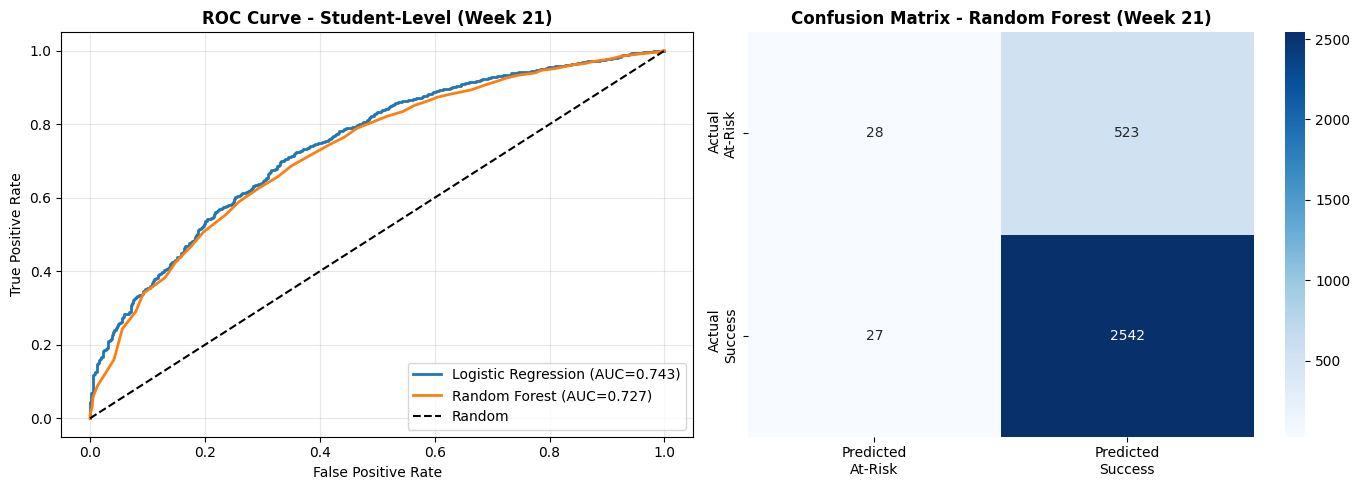

In [59]:
# =============================================================================
# ROC CURVE VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
ax = axes[0]
for name, pipeline in [("Logistic Regression", logreg_pipeline), ("Random Forest", rf_pipeline)]:
    proba = pipeline.predict_proba(X_eval_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_eval_test, proba)
    auc = roc_auc_score(y_eval_test, proba)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label="Random")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC Curve - Student-Level (Week {PRED_WEEK})", fontweight="bold")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

# Confusion Matrix Heatmap
ax = axes[1]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=["Predicted\nAt-Risk", "Predicted\nSuccess"],
            yticklabels=["Actual\nAt-Risk", "Actual\nSuccess"])
ax.set_title(f"Confusion Matrix - Random Forest (Week {PRED_WEEK})", fontweight="bold")

plt.tight_layout()
plt.show()

## 6.3 Compare Prediction Horizons

COMPARING PREDICTION HORIZONS
 Week  ROC-AUC  N_Students
    0 0.692139        4640
    2 0.705811        4740
    4 0.716971        4354
    6 0.698516        4091
    8 0.694365        3717


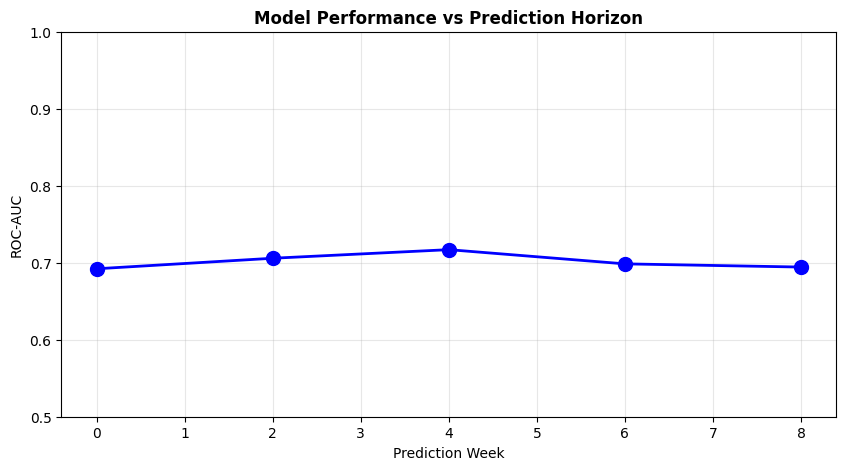


📝 Interpretation: Earlier weeks have less data but allow earlier intervention


In [60]:
# =============================================================================
# COMPARE DIFFERENT PREDICTION WEEKS
# =============================================================================

print("COMPARING PREDICTION HORIZONS")
print("=" * 60)

results = []

for week in [0, 2, 4, 6, 8]:
    # Filter data
    df_week = df_clean[df_clean["week"] <= week].copy()
    
    if df_week.empty:
        continue
    
    # Get evaluation data at this week
    df_eval_week = df_week[df_week["week"] == week].copy()
    
    if len(df_eval_week) < 100:
        continue
    
    # Train/test split
    X_w = df_week.drop(columns=["target_pass"])
    y_w = df_week["target_pass"].astype(int)
    groups_w = df_week["student_id"]
    
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X_w, y_w, groups=groups_w))
    
    X_train_w, X_test_w = X_w.iloc[train_idx], X_w.iloc[test_idx]
    y_train_w, y_test_w = y_w.iloc[train_idx], y_w.iloc[test_idx]
    
    # Train model
    rf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1))
    ])
    rf.fit(X_train_w, y_train_w)
    
    # Evaluate at week point
    test_students_w = set(X_test_w["student_id"])
    X_eval_w = df_eval_week.drop(columns=["target_pass"])
    y_eval_w = df_eval_week["target_pass"].astype(int)
    mask = X_eval_w["student_id"].isin(test_students_w)
    
    if mask.sum() < 50:
        continue
    
    proba = rf.predict_proba(X_eval_w[mask])[:, 1]
    
    results.append({
        "Week": week,
        "ROC-AUC": roc_auc_score(y_eval_w[mask], proba),
        "N_Students": mask.sum()
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Plot
if len(results_df) > 1:
    plt.figure(figsize=(10, 5))
    plt.plot(results_df["Week"], results_df["ROC-AUC"], 'bo-', linewidth=2, markersize=10)
    plt.xlabel("Prediction Week")
    plt.ylabel("ROC-AUC")
    plt.title("Model Performance vs Prediction Horizon", fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 1.0)
    plt.show()
    
    print("\n📝 Interpretation: Earlier weeks have less data but allow earlier intervention")

---

<a id='7'></a>
# 7️⃣ Critique and Limitations

## What This Approach Does Well ✅

| Strength | Description |
|----------|-------------|
| **Temporal framing** | Treats early warning as a time-series problem, matching real-world use |
| **Cumulative features** | Captures engagement trajectory, not just snapshots |
| **GroupShuffleSplit** | Properly prevents data leakage from student overlap |
| **Flexible prediction horizon** | Can evaluate model at different weeks (0, 2, 4, etc.) |
| **Activity type granularity** | Separate features for forum, quiz, resource, etc. |

## Gaps According to Assessment Brief ⚠️

| Missing Element | Assessment Requirement |
|-----------------|------------------------|
| **No clustering** | Brief requires BOTH classification AND clustering |
| **Limited EDA** | Brief requires exploratory data analysis with visualizations |
| **No CRISP-DM structure** | Brief explicitly requires CRISP-DM methodology |
| **Missing business understanding** | No clear problem statement or success criteria |
| **No deployment recommendations** | Brief requires deployment/implementation suggestions |
| **Limited model comparison** | Only compares 2 models, could include more |

## Technical Limitations

1. **High dimensionality**: 60+ cumulative features by activity type may cause overfitting
2. **Class imbalance**: ~74% success rate may bias model toward predicting success
3. **Missing feature engineering**: No ratios, interactions, or derived features
4. **No hyperparameter tuning**: Uses default parameters

## How to Integrate with CRISP-DM Approach

The temporal EWS approach could be **combined** with the CRISP-DM notebook:

1. Use CRISP-DM notebook for **full analysis** (EDA, clustering, evaluation)
2. Use this temporal approach for **early warning classification specifically**
3. Present both in the presentation to show comprehensive analysis

In [61]:
print("=" * 70)
print("                           SUMMARY")
print("=" * 70)
print(f"""
TEMPORAL EARLY WARNING SYSTEM
──────────────────────────────
Approach: Predict student success at specific weeks during the course

Data Structure:
  • {feature_store['student_id'].nunique():,} unique students
  • {feature_store.shape[0]:,} student-week snapshots
  • {len([c for c in feature_store.columns if c.startswith('cum_')])} cumulative VLE features

Key Innovation:
  • One row per student per week (not one row per student)
  • Cumulative features capture engagement trajectory
  • GroupShuffleSplit prevents data leakage

Best Result (Week {PRED_WEEK}):
  • Random Forest ROC-AUC: {roc_auc_score(y_eval_test, proba_rf):.4f}
  
Gaps for Assessment:
  • Missing: Clustering (required by brief)
  • Missing: Full EDA section
  • Missing: CRISP-DM structure
""")
print("=" * 70)

                           SUMMARY

TEMPORAL EARLY WARNING SYSTEM
──────────────────────────────
Approach: Predict student success at specific weeks during the course

Data Structure:
  • 25,521 unique students
  • 625,294 student-week snapshots
  • 122 cumulative VLE features

Key Innovation:
  • One row per student per week (not one row per student)
  • Cumulative features capture engagement trajectory
  • GroupShuffleSplit prevents data leakage

Best Result (Week 21):
  • Random Forest ROC-AUC: 0.7269

Gaps for Assessment:
  • Missing: Clustering (required by brief)
  • Missing: Full EDA section
  • Missing: CRISP-DM structure

